In [11]:
import pandas as pd
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [3]:
%cd ..

c:\Users\celin\git\Quennect


In [13]:
#hyper params
BATCH_SIZE = 100
LR = 0.001
HIDDEN1 = 64
HIDDEN2 = 32

In [20]:
%cd ..

c:\Users\celin\git\Quennect


In [25]:
def prepare_data2():
    q_cleaned_old = pd.read_csv('data/data_vectorized_240228.csv')
    q_cleaned_old.drop(['ia_status_Facility Study', 'ia_status_Feasibility Study',
        'ia_status_IA Executed', 'ia_status_Operational',
        'ia_status_System Impact Study', 'Unnamed: 0'], axis=1, inplace=True)
    cols_to_drop = [col for col in q_cleaned_old.columns if col.startswith('util')]
    q_cleaned_old.drop(cols_to_drop,  axis=1, inplace=True)

    exempt = []
    for col in list(q_cleaned_old.columns):
        if q_cleaned_old[col].max() < 1:
              exempt.append(col)
    q_cleaned_old.drop(columns = exempt,axis=1, inplace=True)

    target = q_cleaned_old['ia_status_Withdrawn']
    features = q_cleaned_old.drop('ia_status_Withdrawn', axis=1)

    scaler = StandardScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

    seed = 42
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target,
                                                        test_size = 0.2,
                                                        random_state = seed)
    return X_train, X_test, y_train, y_test



In [41]:
def prepare_data():
    q_cleaned_old = pd.read_csv('mid_cleaning_240228.csv')
    q_cleaned_old.drop(['ia_status_Facility Study', 'ia_status_Feasibility Study',
        'ia_status_IA Executed', 'ia_status_Operational',
        'ia_status_System Impact Study', 'Unnamed: 0'], axis = 1, inplace=True)
    
    deregulated_electricity_markets = ['OR', 'CA', 'TX', 'IL', 'MI', 'OH', 'VA', 'MD', 'DE', 'PA', 'NJ', 'NY', 'MA', 'CT', 'RI', 'NH', 'ME']
    q_cleaned_old['is_deregulated'] = q_cleaned_old['state'].isin(deregulated_electricity_markets).astype(int)
    
    has_100_percent_clean_energy_goal = ['CA', 'CO', 'CT', 'DE', 'HI', 'IL', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NE', 'NV', 'NJ', 'NM', 'NY', 'NC', 'OR', 'RI', 'VA', 'WA', 'WI']
    q_cleaned_old['has_100_clean_energy_goal'] = q_cleaned_old['state'].isin(has_100_percent_clean_energy_goal).astype(int)
    
    top_ten_renewable_generators = ['TX', 'FL', 'PA', 'CA', 'IL', 'AL', 'OH', 'NC', 'GA', 'NY']
    q_cleaned_old['top_ten_renewable_generators'] = q_cleaned_old['state'].isin(top_ten_renewable_generators).astype(int)
    
    
    q_cleaned_old['is_solar'] = (q_cleaned_old['type1_Solar'] == 1).astype(int)
    
    q_cleaned_old['is_storage'] = ((q_cleaned_old['type1_Battery'] == 1) |
                                    (q_cleaned_old['type1_Hydro'] == 1) |
                                    (q_cleaned_old['type1_Gravity Rail'] == 1) |
                                    (q_cleaned_old['type1_Flywheel'] == 1) |
                                    (q_cleaned_old['type1_Pumped Storage'] == 1)).astype(int)
    
    q_cleaned_old['is_wind'] = ((q_cleaned_old['type1_Offshore Wind'] == 1) |
                                (q_cleaned_old['type1_Wind'] == 1)).astype(int)

    q_cleaned_old['is_bioenergy'] = ((q_cleaned_old['type1_Biofuel'] == 1) |
                                    (q_cleaned_old['type1_Biogas'] == 1) |
                                    (q_cleaned_old['type1_Biomass'] == 1) |
                                    (q_cleaned_old['type1_Wood'] == 1)).astype(int)

    q_cleaned_old['is_wasteuse'] = ((q_cleaned_old['type1_Landfill'] == 1) |
                                    (q_cleaned_old['type1_Methane'] == 1) |
                                    (q_cleaned_old['type1_Waste Heat'] == 1)).astype(int)

    q_cleaned_old['is_cleanenergy'] = ((q_cleaned_old['type1_Geothermal'] == 1) |
                                    (q_cleaned_old['type1_Nuclear'] == 1) |
                                    (q_cleaned_old['type1_Solar'] == 1) |
                                    (q_cleaned_old['type1_Offshore Wind'] == 1) |
                                    (q_cleaned_old['type1_Hydro'] == 1) |
                                    (q_cleaned_old['type1_Wind'] == 1)).astype(int)

    q_cleaned_old['is_fossilfuels'] = ((q_cleaned_old['type1_Coal'] == 1) |
                                    (q_cleaned_old['type1_Diesel'] == 1) |
                                    (q_cleaned_old['type1_Gas'] == 1) |
                                    (q_cleaned_old['type1_Oil'] == 1) |
                                    (q_cleaned_old['type1_Steam'] == 1)).astype(int)

    q_cleaned_old['is_hybrid'] = (q_cleaned_old['type1_Hybrid'] == 1).astype(int)
    
    high_revenue_utilities = ['SOCO', 'Duke Energy Indiana, LLC', 'Duke_FL','Duke Energy Corporation',
                              'Duke Energy', 'Duke', 'PGE', 'AEP', 'DominionSC', 'Dominion SC', 'Dominion']
    q_cleaned_old['high_revenue_utility'] = q_cleaned_old['utility'].isin(high_revenue_utilities).astype(int)
    
    q_cleaned_old.drop(['q_date', 'state', 'entity', 'utility', 'county_1'], axis = 1, inplace=True)
    q_cleaned_old.drop(['Join_Count','Join_Count_1','Join_Count_12','TARGET_FID_12','Join_Count_12_13','TARGET_FID_12_13'], axis = 1, inplace=True)
    q_cleaned_old.drop(['name', 'power', 'substation', 'type', 'LEGAL_NAME', 'tokens.1'], axis = 1, inplace=True)
  
    q_cleaned_old.rename(columns={'q_year': 'year_entering_queue', 
                'prop_year': 'proposed_year',
                'total_mw': 'project_size_mw',
                'Lat': 'project_latitude',
                'Long': 'project_longitude',
                'POP_SQMI': 'population_density',
                'votes_per_sqkm': 'voting_density',
                'solar_ann_ghi_rn': 'solar_potential',
                'avg_wind_speed_meters_per_second': 'wind_potential'}, inplace=True)
    
    cleaned_columns = ['year_entering_queue', 'proposed_year', 'region_CAISO', 'region_MISO',
       'region_PJM', 'region_Southeast (non-ISO)', 'region_West (non-ISO)',
       'project_size_mw', 'project_latitude','project_longitude', 'population_density',
       'votes_dem', 'votes_rep', 'votes_total', 'voting_density',
       'pct_dem_lead', 'solar_potential', 'wind_potential', 'is_deregulated',
       'has_100_clean_energy_goal', 'top_ten_renewable_generators', 'is_solar',
       'is_storage', 'is_wind', 'is_bioenergy', 'is_wasteuse',
       'is_cleanenergy', 'is_fossilfuels', 'is_hybrid',
       'high_revenue_utility', 'ia_status_Withdrawn']
    
    exempt = []
    for col in list(q_cleaned_old.columns):
        if col not in cleaned_columns:
            exempt.append(col)
        if 'type1' in col:
            exempt.append(col)
    q_cleaned_old.drop(columns = exempt, inplace=True)  
    
    # return q_cleaned_old
    
    scaler = StandardScaler()
    scaler.fit(q_cleaned_old)
    q_cleaned_array = scaler.transform(q_cleaned_old)
    q_cleaned = pd.DataFrame(q_cleaned_array, columns=q_cleaned_old.columns)
    

    target = q_cleaned_old['ia_status_Withdrawn']
    features = q_cleaned.drop(['ia_status_Withdrawn'], axis = 1)
    q_cleaned.drop(['ia_status_Withdrawn'], axis = 1, inplace=True)

    seed = 42

    X_train, X_test, y_train, y_test = train_test_split(q_cleaned, target,
                                                        test_size = 0.2,
                                                        random_state = seed)
    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = prepare_data()

In [43]:
X_train.columns

Index(['year_entering_queue', 'proposed_year', 'region_CAISO', 'region_MISO',
       'region_PJM', 'region_Southeast (non-ISO)', 'region_West (non-ISO)',
       'project_size_mw', 'project_latitude', 'project_longitude',
       'population_density', 'votes_dem', 'votes_rep', 'votes_total',
       'voting_density', 'pct_dem_lead', 'solar_potential', 'wind_potential',
       'is_deregulated', 'has_100_clean_energy_goal',
       'top_ten_renewable_generators', 'is_solar', 'is_storage', 'is_wind',
       'is_bioenergy', 'is_wasteuse', 'is_cleanenergy', 'is_fossilfuels',
       'is_hybrid', 'high_revenue_utility'],
      dtype='object')

In [44]:
class Q_vecDataset(Dataset):
    def __init__(self, X, y, train):
        self.feature = X
        self.target = y
        self.train = train

    def __len__(self):
        return self.target.shape[0]

    def __getitem__(self, index):
        X = self.feature.iloc[index,:]
        X = X.to_numpy()
        y = self.target.iloc[index]

        return X, y

train_q_vec = Q_vecDataset(X=X_train, y=y_train, train=True)
test_q_vec = Q_vecDataset(X=X_test, y=y_test, train=False)

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_q_vec, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_q_vec, batch_size=batch_size, shuffle=False)
input_size = X_train.shape[1]
print(f"Input size: {input_size}")

Input size: 30


In [45]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

hidden1 = HIDDEN1
hidden2 = HIDDEN2

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return(x)



In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [57]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
test_f1, t_labels, t_preds = [], [], []

num_epochs = 1000
for epoch in range(num_epochs):
    #train
    model.train()
    run_loss = 0
    run_correct = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).to(torch.float32)
        labels = labels.to(device)

        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        run_loss += loss.item()*inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        run_correct += (preds == labels).type(torch.float32).sum().item()

    epoch_loss = run_loss / len(train_dataloader.dataset)
    epoch_acc = run_correct / len(train_dataloader.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    #test
    model.eval()
    test_run_loss = 0
    test_run_correct = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device).to(torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            t_loss = criterion(outputs, labels)
            test_run_loss += t_loss.item()*inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            test_run_correct += (preds == labels).type(torch.float32).sum().item()
            t_labels.extend(labels.tolist())
            t_preds.extend(preds.tolist())


    epoch_test_loss = test_run_loss / len(test_dataloader.dataset)
    epoch_test_acc = test_run_correct / len(test_dataloader.dataset)
    f1 = f1_score(t_labels, t_preds, average='binary')

    test_f1.append(f1)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    print(epoch)
    print(f"train loss: {epoch_loss}, test loss: {epoch_test_loss}")
    print(f"train acc: {epoch_acc}, test acc: {epoch_test_acc}")
    print(f"F1: {f1}")

0
train loss: 0.41578564583493843, test loss: 0.5402484132643164
train acc: 0.905565693430657, test acc: 0.8695255474452555
F1: 0.5431309904153354
1
train loss: 0.41649146921878316, test loss: 0.5452776231469899
train acc: 0.9076186131386861, test acc: 0.8667883211678832
F1: 0.5390749601275917
2
train loss: 0.4135757064188484, test loss: 0.5400613313608796
train acc: 0.9105839416058394, test acc: 0.8622262773722628
F1: 0.5358649789029536
3
train loss: 0.4126938552099423, test loss: 0.5414236668687668
train acc: 0.916058394160584, test acc: 0.8631386861313869
F1: 0.5347003154574133
4
train loss: 0.4192604605842681, test loss: 0.5380704513866535
train acc: 0.9067062043795621, test acc: 0.8731751824817519
F1: 0.5383153894870171
5
train loss: 0.41088500760332514, test loss: 0.5317706782234847
train acc: 0.9144616788321168, test acc: 0.8713503649635036
F1: 0.5411392405063291
6
train loss: 0.4172695890123392, test loss: 0.528274912033638
train acc: 0.9037408759124088, test acc: 0.86222627737

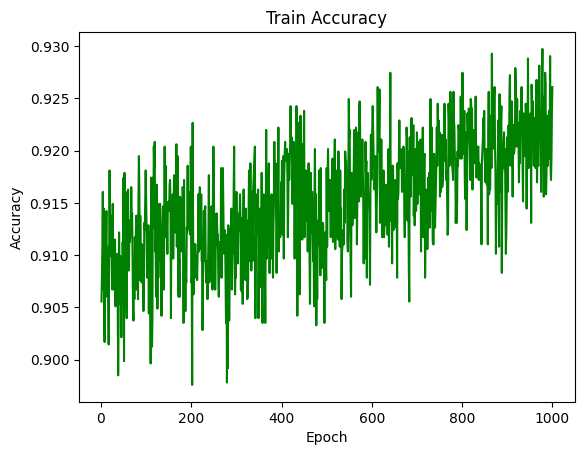

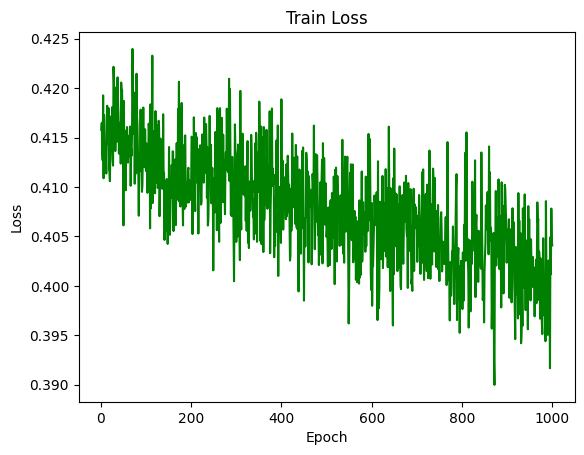

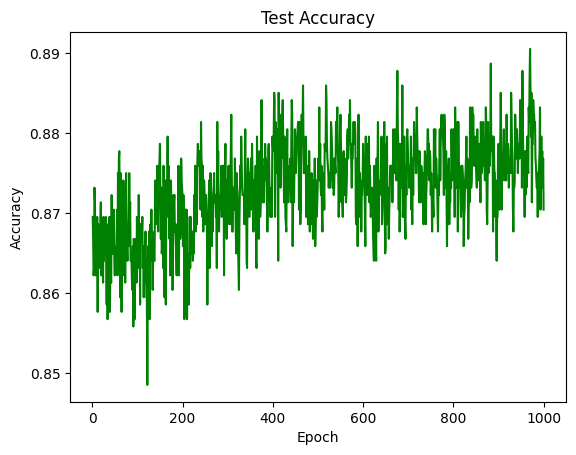

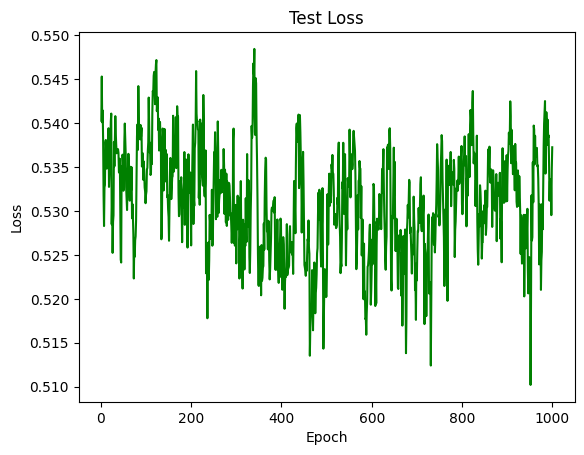

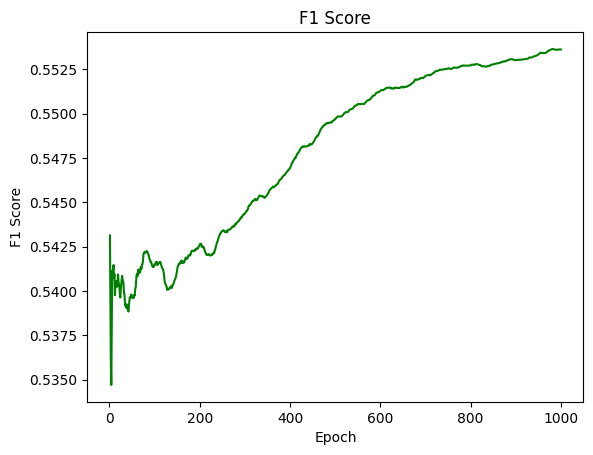

In [58]:
plt.plot(np.arange(1, num_epochs+1), train_acc, color='green')
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.arange(1, num_epochs+1), train_loss, color='green')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(1, num_epochs+1), test_acc, color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.arange(1, num_epochs+1), test_loss, color='green')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(1, num_epochs+1),  test_f1, color='green')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()

In [59]:
torch.save(model.state_dict(), 'model_full_state_dict_epoch1k.pth')

In [60]:
torch.save(model.state_dict(), 'model_full_state_dict_epoch1k.pt')

In [108]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model_full_state_dict.pth'))

<All keys matched successfully>